# Text Mining Chapter 4 - Data Preparation for Statistical Analysis
May 2022

After studying this chapter, you will know the required and optional steps of data
preparation. You will know how to use regular expressions for data cleaning and how
to use spaCy for feature extraction. With the provided blueprints you will be able to
quickly set up a data preparation pipeline for your own project.

### Contents
[Section 1 - Data Extraction](#section_1)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[Section 1.b - If you are running this on localhost, begin here.](#section_0)<br>
[Section 2 - Data Cleanup with Regex](#section_2)<br>
[Section 3 - Processing: Tokenization](#section_3)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[Section 3b - Customizing Tokenization](#section_3b)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[Section 3c - Stop Words](#section_3c)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[Section 3d - Lemmas](#section_3d)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[Section 3e - Extracting Noun Phrases](#section_3e)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[Section 3f - Named Entities](#section_3f)<br>
[Section 4 - Combining All Processing with Spacy](#section_4)<br>

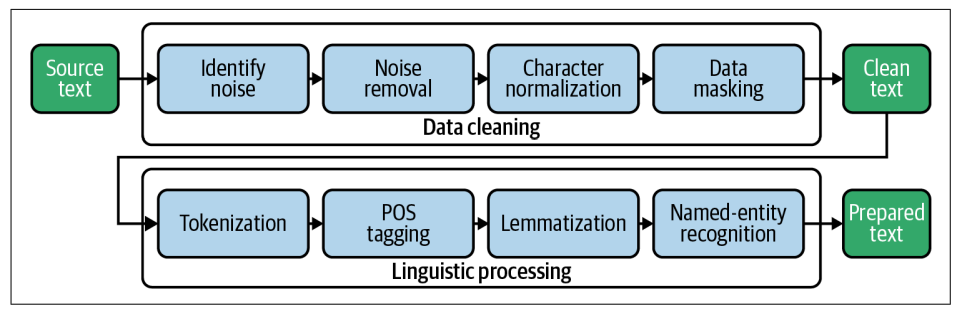

<a id='section_1'></a>
## Section 1: Data Extraction
<p><i><b>
    Context:</b> The reddit self-post dataset contains over 1m posts, with ~1K from 1k different subreddits. We also have a separate document of metadata which is loaded separately and joined to create one dataframe. in this instance, we will be using only 20k posts as a sample.
</i> 
<p>You can locate the dataset <a href=''>here</a>.</p>
</p>

We have stored our data in an S3 environment so we need to invoke boto3 to make initial data pulls feasible.

In [193]:
# #our dataset, however, is stored inside our S3 environment, so we load in our s3 capabilities.
# import boto3
# import sagemaker
# import pandas as pd 
# sess = sagemaker.Session()
# bucket = sess.default_bucket()
# role = sagemaker.get_execution_role()
# region = boto3.Session().region_name

we begin by pulling in the tsv and the metadata files from S3 in the reddit-self-post-data bucket.

In [3]:
source_bucket = 'reddit-self-post-data'
s3 = boto3.client('s3') 

#load in the reddit posts
obj = s3.get_object(Bucket= source_bucket, Key= 'rspct.tsv') 
df = pd.read_csv(obj['Body'],sep='\t')

#load in the metadata to filter them down.
obj = s3.get_object(Bucket= source_bucket, Key= 'subreddit_info.csv')
df_adj = pd.read_csv(obj['Body'])

merge the two datasets together. We want to sample 20,000 data points that all belong to the auto category.

In [4]:
#filter down the adjacent metadata to only autos.
df_adj = df_adj.query("category_1=='autos'")
#inner join and sample 20k
df = df.merge(
    right=df_adj,
    how='inner',
    on='subreddit'
).sample(20000)

It's best practice to rename columns to things that are more generic like text, category subcategory, etc.

In [5]:
#rename our columns
column_mapping = {
 'id': 'id',
 'subreddit': 'subreddit',
 'title': 'title',
 'selftext': 'text',
 'category_1': 'category',
 'category_2': 'subcategory',
 'category_3': None, # no data
 'in_data': None, # not needed
 'reason_for_exclusion': None # not needed
}
# define remaining columns
columns = [c for c in column_mapping.keys() if column_mapping[c] != None]
# select and rename those columns
df = df[columns].rename(columns=column_mapping)
#sanity check
df.head()

,id,subreddit,title,text,category,subcategory
11180,7ujyck,subaru,Any input over what sounds like a recurring lo...,"Last Friday, I went to start my Legacy after i...",autos,subaru
14152,81fgfw,BMW,2018 BMW X3 M40i wheels and rims?,I just ordered a X3 M40i. It comes with summer...,autos,bmw
11965,55bhfg,subaru,Bluetooth audio issue in my Crosstrek,Hello! I've got a problem getting my BT-audio ...,autos,subaru
12557,4qhlak,Porsche,Porsche 928 thread,I have wanted a 928 ever since I was a kid. I...,autos,porsche
17836,824p7x,MPSelectMiniOwners,Possible Short on Power Switch- Advice Needed,"Hey everyone,<lb><lb>Here is a [possible short...",autos,mini


In [9]:
#clean up memory so our kernel doesn't crash
del df_adj

In [6]:
#save to pickle as a checkpoint
df.to_pickle("reddit_dataframe.pkl")

In [ ]:
#but we'd rather store in SQL.
import sqlite3
db_name = "reddit-selfposts.db"
con = sqlite3.connect(db_name)
df.to_sql("posts", con, index=False, if_exists="replace")
con.close()

<a id='section_0'></a>
## If you are running this notebook on a local instance, begin execution here.
<p>Because we don't have access to our sagemaker environment on local host, we will begin this exercise by reading in a sqlite file.</p>

In [125]:
import pandas as pd 
#proof that we can bring it back easily
con = sqlite3.connect(db_name)
df = pd.read_sql("select * from posts", con)
con.close()
df.head()

,id,subreddit,title,text,category,subcategory
0,7ujyck,subaru,Any input over what sounds like a recurring lo...,"Last Friday, I went to start my Legacy after i...",autos,subaru
1,81fgfw,BMW,2018 BMW X3 M40i wheels and rims?,I just ordered a X3 M40i. It comes with summer...,autos,bmw
2,55bhfg,subaru,Bluetooth audio issue in my Crosstrek,Hello! I've got a problem getting my BT-audio ...,autos,subaru
3,4qhlak,Porsche,Porsche 928 thread,I have wanted a 928 ever since I was a kid. I...,autos,porsche
4,824p7x,MPSelectMiniOwners,Possible Short on Power Switch- Advice Needed,"Hey everyone,<lb><lb>Here is a [possible short...",autos,mini


<a id='section_2'></a>
## Section 2: Data Cleanup with Regex
<p><i><b>
    Context:</b> In cleaning user posts, we have several issues to consider:
    <ul>
        <li>HTML,Markdown Tags, etc.</li>
        <li>Meaningless personal salutations and signatures.</li>
        <li>Replies, which can skew the statistical performance by duplicating documents.</li>
    </ul>
</i> 
</p>

### Identifying noise with regex

In [126]:
import re
RE_SUSPICIOUS = re.compile(r'[&#<>{}\[\]\\]')
#define some sketchy text
text = """
After viewing the [PINKIEPOOL Trailer](https://www.youtu.be/watch?v=ieHRoHUg)
it got me thinking about the best match ups.
<lb>Here's my take:<lb><lb>[](/sp)[](/ppseesyou) Deadpool<lb>[](/sp)[](/ajsly)
Captain America<lb>"""

def impurity(text, min_len=10):
    """returns the share of suspicious characters in a text"""
    if text == None or len(text) < min_len:
        return 0
    else:
        return len(RE_SUSPICIOUS.findall(text))/len(text)
    
print(impurity(text))

0.09009009009009009


It's very likely that the rest of our dataset probably has impurities just like this, so we can apply a mapping function to the entire df to check for impurity.

In [127]:
df['impurity'] = df['text'].apply(impurity,min_len=10)
# get the top 3 records
df[['text', 'impurity']].sort_values(by='impurity', ascending=False).head(3)

,text,impurity
16690,Looking at buying a 335i with 39k miles and 11...,0.214716
12044,I'm looking to lease an a4 premium plus automa...,0.165099
11136,Breakdown below:<lb><lb>Elantra GT<lb><lb>2.0L...,0.139130


There's a lot of tags / html in our text, so we can filter them out using the regex expression
'<[\w/]*>'
<br>
This expression looks for any string that begins with a < and ends with a >, and contains either a word or a closing slash inside of the two tags.

In [128]:
from collections import Counter
def count_words(df, column='tokens', preprocess=None, min_freq=2):
    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)
    # create counter and run through all data
    counter = Counter()
    df[column].map(update)
    # transform counter into a DataFrame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    return freq_df.sort_values('freq', ascending=False)

In [129]:
#let's see how many tags exist in the text.
count_words(df, column='text', preprocess=lambda t: re.findall(r'<[\w/]*>', t))

,freq
token,
<lb>,100729
<tab>,642


We can conclude that although these tags are common, there aren't any other ones.

### Cleaning HTML with regex

In [130]:
import html
def clean(text):
    # convert html escapes like &amp; to characters.
    text = html.unescape(text)
    # tags like <tab> --> this removes anything enclosed in <> that isn't another pair of <>.
    text = re.sub(r'<[^<>]*>', ' ', text)
    # markdown URLs like [Some text](https://....)
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
    # text or code in brackets like [0]
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    # standalone sequences of specials, matches &# but not #cool
    text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text)
    # standalone sequences of hyphens like --- or ==
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    # sequences of white spaces
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

In [131]:
#run this func and check if it worked
df['clean_text'] = df['text'].map(clean)
df['impurity'] = df['clean_text'].apply(impurity, min_len=20)
df[['clean_text', 'impurity']].sort_values(by='impurity', ascending=False) \
 .head(3)

,clean_text,impurity
16052,"Mustang 2018, 2019, or 2020? Must Haves!! 1. H...",0.030864
6290,"At the dealership, they offered an option for ...",0.026455
19349,"I am looking at four Caymans, all are in a sim...",0.024631


### Character Normalization with textacy
Use cases:
Saint-Raphaël and Saint-Raphael are the same phrase, but won't be recognized as such because of special characters. words separated by line breaks often have a dash included in them, which makes reconciliation difficult as well. To fix this, we replace everything with its ASCII equivalent.

In [132]:
from textacy import preprocessing
def normalize(text):
    text = preprocessing.normalize.hyphenated_words(text)
    text = preprocessing.normalize.quotation_marks(text)
    text = preprocessing.normalize.unicode(text)
    text = preprocessing.remove.accents(text)
    return text

In [133]:
text = "The café “Saint-Raphaël” is loca-\nted on Côte dʼAzur."
normalize(text)

'The cafe "Saint-Raphael" is located on Cote d\'Azur.'

### Character Masking with textacy
Use cases:
Sometimes we need to protect the privacy of users and posters by removing URLs, emails, and other sensitive information.

In [134]:
from textacy.preprocessing.resources import RE_URL
count_words(df, column='clean_text', preprocess=RE_URL.findall).head(3)

,freq
token,
www.getlowered.com,3
https://imgur.com/a/MXnni),2
https://imgur.com/a/mbS08,2


to protect the privacy of the users whose posts we are analysing, we will invoke the ```replace_urls``` function.

In [135]:
text = "Check out https://spacy.io/usage/spacy-101"
# using default substitution _URL_
print(preprocessing.replace.urls(text))

Check out _URL_


In [136]:
#let's run the entire pipeline!
df['clean_text'] = df['clean_text'].map(preprocessing.replace.urls)
df['clean_text'] = df['clean_text'].map(normalize)
df.head()

,id,subreddit,title,text,category,subcategory,impurity,clean_text
0,7ujyck,subaru,Any input over what sounds like a recurring lo...,"Last Friday, I went to start my Legacy after i...",autos,subaru,0.0,"Last Friday, I went to start my Legacy after i..."
1,81fgfw,BMW,2018 BMW X3 M40i wheels and rims?,I just ordered a X3 M40i. It comes with summer...,autos,bmw,0.0,I just ordered a X3 M40i. It comes with summer...
2,55bhfg,subaru,Bluetooth audio issue in my Crosstrek,Hello! I've got a problem getting my BT-audio ...,autos,subaru,0.0,Hello! I've got a problem getting my BT-audio ...
3,4qhlak,Porsche,Porsche 928 thread,I have wanted a 928 ever since I was a kid. I...,autos,porsche,0.0,I have wanted a 928 ever since I was a kid. I ...
4,824p7x,MPSelectMiniOwners,Possible Short on Power Switch- Advice Needed,"Hey everyone,<lb><lb>Here is a [possible short...",autos,mini,0.0,"Hey everyone, Here is a possible short that I ..."


now that we're done thoroughly cleaning all of our data, we can rename the columns for working purposes.

In [137]:
df.rename(columns={'text':'raw_text','clean_text':'text'},inplace=True)
df.drop(columns='impurity',inplace=True)
#after renaming, push it into an sqlite file
con = sqlite3.connect(db_name)
df.to_sql("posts_cleaned", con, index=False, if_exists="replace")
con.close()

<a id='section_3'></a>
## Section 3: Processing - Tokenization
tokenization is complex and has no rigid definition. Separation by spaces only can leave us with a loss of information on characters such as emojis, and even POSIX patters like /w/w+ can cause a loss of integrity, so we create a more complicated version.

All tokenizers are different, here are some edge cases to watch out for:
<ul>
<li>Tokens containing periods, such as Dr., Mrs., U., xyz.com</li>
<li>Hyphens, like in rule-based</li>
<li>Clitics (connected word abbreviations), like in couldn't, we've or je t'aime</li>
<li>Numerical expressions, such as telephone numbers ((123) 456-7890) or dates</li>
(August 7th, 2019)
<li>Emojis, hashtags, email addresses, or URLs</li>
</ul>

In [138]:
RE_TOKEN = re.compile(r"""
 ( [#]?[@\w'’\.\-\:]*\w # words, hashtags and email addresses
 | [:;<]\-?[\)\(3] # coarse pattern for basic text emojis
 | [\U0001F100-\U0001FFFF] # coarse code range for unicode emojis
 )
 """, re.VERBOSE)
def tokenize(text):
    return RE_TOKEN.findall(text)


In [139]:
text = """
2019-08-10 23:32: @pete/@louis - I don't have a well-designed
solution for today's problem. The code of module AC68 should be -1.
Have to think a bit... #goodnight ;-) ᥌᥏"""
tokens = tokenize(text)
print(*tokens, sep='|')

2019-08-10|23:32|@pete|@louis|I|don't|have|a|well-designed|solution|for|today's|problem|The|code|of|module|AC68|should|be|-1|Have|to|think|a|bit|#goodnight|;-)|᥌᥏


we can also use the NLTK package for tokenization to make life easier for us.

In [140]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fkrasovsky\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [141]:
tokens = nltk.tokenize.word_tokenize(text)
print(*tokens, sep='|')

2019-08-10|23:32|:|@|pete/|@|louis|-|I|do|n't|have|a|well-designed|solution|for|today|'s|problem|.|The|code|of|module|AC68|should|be|-1|.|Have|to|think|a|bit|...|#|goodnight|;|-|)|᥌᥏


#### Linguistic Preprocessing with Spacy
Spacy is a tokenizer that handles the entire preprocessing pipeline that can handle tagging, POS recognition, masking, named entity recognition, and more.
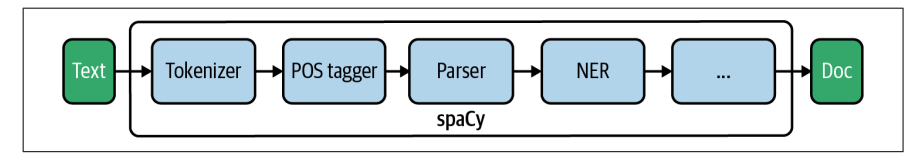

In [142]:
!python -m spacy download en_core_web_sm

[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [143]:
#instantiating a pipeline - we will begin by loading in a small english language library.
import spacy
nlp = spacy.load('en_core_web_sm')

previous versions of spacy come with a tagger, a parser, and a named entity recognizer.
In this case we only want the tokenizer and the part of speech tagger

In [145]:
#create our pipeline that only consists of tokenizer and pos tagger
nlp = spacy.load('en_core_web_sm',disable=['parser','attribute_ruler','lemmatizer','ner'])

In [146]:
nlp.pipeline

[('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec at 0x1213e70aca0>),
 ('tagger', <spacy.pipeline.tagger.Tagger at 0x1213e70ad60>)]

In [147]:
nlp = spacy.load('en_core_web_sm')
text = "My best friend Ryan Peters likes fancy adventure games."
doc = nlp(text)

##### Spacy is designed to retain the original text but is also a container for other properties like tokens, POS taggers, lemmas, and more. we can create a helper function that generates a table of each token and their attributes:

In [148]:
def display_nlp(doc, include_punct=False):
    """Generate data frame for visualization of spaCy tokens."""
    rows = []
    for i, t in enumerate(doc):
        if not t.is_punct or include_punct:
            row = {'token': i, 'text': t.text, 'lemma_': t.lemma_,
                'is_stop': t.is_stop, 'is_alpha': t.is_alpha,
                'pos_': t.pos_, 'dep_': t.dep_,
                'ent_type_': t.ent_type_, 'ent_iob_': t.ent_iob_}
            rows.append(row)
    df = pd.DataFrame(rows).set_index('token')
    df.index.name = None
    return df

In [149]:
display_nlp(doc)

,text,lemma_,is_stop,is_alpha,pos_,dep_,ent_type_,ent_iob_
0,My,my,True,True,PRON,poss,,O
1,best,good,False,True,ADJ,amod,,O
2,friend,friend,False,True,NOUN,nsubj,,O
3,Ryan,Ryan,False,True,PROPN,compound,PERSON,B
4,Peters,Peters,False,True,PROPN,appos,PERSON,I
5,likes,like,False,True,VERB,ROOT,,O
6,fancy,fancy,False,True,ADJ,amod,,O
7,adventure,adventure,False,True,NOUN,compound,,O
8,games,game,False,True,NOUN,dobj,,O


<a id='section_3b'></a>
### Section 3b: Customizing Tokenization

In [150]:
from spacy.tokenizer import Tokenizer
from spacy.util import compile_prefix_regex, \
 compile_infix_regex, compile_suffix_regex

def custom_tokenizer(nlp):
    
    # use default patterns except the ones matched by re.search
    prefixes = [pattern for pattern in nlp.Defaults.prefixes if pattern not in ['-', '_', '#']]
    suffixes = [pattern for pattern in nlp.Defaults.suffixes if pattern not in ['_']]
    infixes = [pattern for pattern in nlp.Defaults.infixes if not re.search(pattern, 'xx-xx')]
    
    return Tokenizer(vocab = nlp.vocab,
        rules = nlp.Defaults.tokenizer_exceptions,
        prefix_search = compile_prefix_regex(prefixes).search,
        suffix_search = compile_suffix_regex(suffixes).search,
        infix_finditer = compile_infix_regex(infixes).finditer,
        token_match = nlp.Defaults.token_match)

In [151]:
text = "@Pete: choose low-carb #food #eat-smart. _url_ ;-) ᤮ᝰ"
nlp.tokenizer = custom_tokenizer(nlp)
doc = nlp(text)
for token in doc:
     print(token, end="|")

@Pete|:|choose|low-carb|#food|#eat-smart|.|_url_|;-)|᤮ᝰ|

<a id='section_3c'></a>
### Section 3c: Working with Stop Words

Spacy comes prebuilt with a collection of stop words that are easy to filter out using ```if not .is_stop``` when we loop through the tokens in a doc built by spacy.

In [152]:
text = "Dear Ryan, we need to sit down and talk. Regards, Pete"
doc = nlp(text)
non_stop = [t for t in doc if not t.is_stop and not t.is_punct]
print(non_stop)

[Dear, Ryan, need, sit, talk, Regards, Pete]


we can also customize which words are stop words for context:

In [153]:
nlp.vocab['down'].is_stop = False
nlp.vocab['and'].is_stop= False 
doc = nlp(text)
non_stop = [t for t in doc if not t.is_stop and not t.is_punct]
print(non_stop)

[Dear, Ryan, need, sit, down, and, talk, Regards, Pete]


<a id='section_3d'></a>
### Section 3d: Extracting Lemmas based on parts of speech

Lemmas are the root, uninflected version of a word, such as meet being the lemma of meeting. Lemmatization allows us to condense many different words into one and save processing space and provides greater statistical performance than non-lemmatized words.

In [154]:
text = "My best friends, Jack Sparrow and Ryan Peters loves fanciful adventurous games."
doc = nlp(text)
print(*[t.lemma_ for t in doc], sep='|')

my|good|friend|,|Jack|Sparrow|and|Ryan|Peters|love|fanciful|adventurous|game|.


In [155]:
#we can also filter by parts of speech
text = "My best friend Ryan Peters likes fancy adventure games."
doc = nlp(text)
nouns = [t for t in doc if t.pos_ in ['NOUN', 'PROPN']]
print(nouns)

[friend, Ryan, Peters, adventure, games]


In [156]:
tokens = textacy.extract.words(doc,
    filter_stops = True, # default True, no stopwords
    filter_punct = True, # default True, no punctuation
    filter_nums = True, # default False, no numbers
    include_pos = ['ADJ', 'NOUN'], # default None = include all
    exclude_pos = None, # default None = exclude none
    min_freq = 1) # minimum frequency of words
print(*[t for t in tokens], sep='|')

best|friend|fancy|adventure|games


In [157]:
def extract_lemmas(doc, **kwargs):
     return [t.lemma_ for t in textacy.extract.words(doc, **kwargs)]
lemmas = extract_lemmas(doc, include_pos=['VERB'])
print(*lemmas, sep='|')

like


<a id='section_3e'></a>
### Section 3e: Extracting Noun Phrases 
Recall the N-gram analysis we concluded was relevant for identifying insights - best-friend, partner-in-crime, united nations, etc. However, many n-grams such as like - friend, my - best, and others have no meaning. we can find meaningful n-grams by analyzing parts of speech such as adj-noun:

In [158]:
text = "My best friend Ryan Peters likes fancy adventure games."
doc = nlp(text)
patterns = ["POS:ADJ POS:NOUN:+"]
spans = textacy.extract.matches.token_matches(doc, patterns=patterns)
print(*[s.lemma_ for s in spans], sep='|')

good friend|fancy adventure|fancy adventure game


In [159]:
def extract_noun_phrases(doc, preceding_pos=['NOUN'], sep='_'):
    patterns = []
    for pos in preceding_pos:
        patterns.append(f"POS:{pos} POS:NOUN:+")
    spans = textacy.extract.matches.token_matches(doc, patterns=patterns)
    return [sep.join([t.lemma_ for t in s]) for s in spans]

print(*extract_noun_phrases(doc, ['ADJ', 'NOUN']), sep='|')

good_friend|fancy_adventure|fancy_adventure_game|adventure_game


<a id='section_3f'></a>
### Section 3f: Named Entities
Named-entity recognition refers to the process of detecting entities such as
people, locations, or organizations in text. Each entity can consist of one
or more tokens, like San Francisco.

In [160]:
text = "James O'Neill, chairman of World Cargo Inc, lives in San Francisco."
doc = nlp(text)
for ent in doc.ents:
     print(f"({ent.text}, {ent.label_})", end=" ")

(James O'Neill, PERSON) (World Cargo Inc, ORG) (San Francisco, GPE) 

In [161]:
from spacy import displacy
displacy.render(doc, style='ent')

**From here, we can crate a custom function that extracts particular forms of named entities.**

In [162]:
def extract_entities(doc, include_types=None, sep='_'):
    ents = textacy.extract.entities(doc,
    include_types=include_types,
    exclude_types=None,
    drop_determiners=True,
    min_freq=1)
    return [sep.join([t.lemma_ for t in e])+'/'+e.label_ for e in ents]

In [163]:
print(extract_entities(doc, ['PERSON', 'GPE']))

["James_O'Neill/PERSON", 'San_Francisco/GPE']


<a id='section_4'></a>
## Putting Analysis Together with Spacy

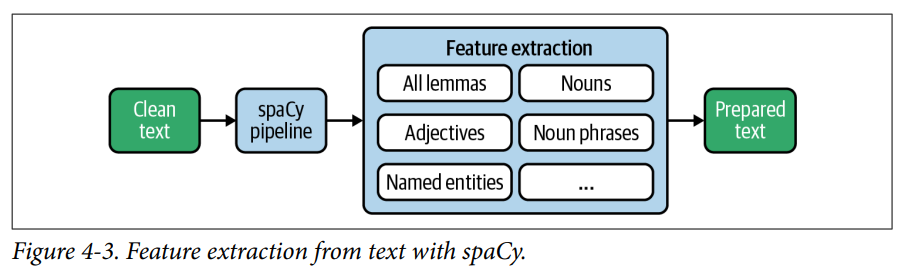

In [164]:
def extract_nlp(doc):
    return {
        'lemmas' : extract_lemmas(doc,
        exclude_pos = ['PART', 'PUNCT',
        'DET', 'PRON', 'SYM', 'SPACE'],
        filter_stops = False),
        'adjs_verbs' : extract_lemmas(doc, include_pos = ['ADJ', 'VERB']),
        'nouns' : extract_lemmas(doc, include_pos = ['NOUN', 'PROPN']),
        'noun_phrases' : extract_noun_phrases(doc, ['NOUN']),
        'adj_noun_phrases': extract_noun_phrases(doc, ['ADJ']),
        'entities' : extract_entities(doc, ['PERSON', 'ORG', 'GPE', 'LOC'])
    }

In [165]:
text = "My best friend Ryan Peters likes fancy adventure games."
doc = nlp(text)
for col, values in extract_nlp(doc).items():
    print(f"{col}: {values}")

lemmas: ['good', 'friend', 'Ryan', 'Peters', 'like', 'fancy', 'adventure', 'game']
adjs_verbs: ['good', 'like', 'fancy']
nouns: ['friend', 'Ryan', 'Peters', 'adventure', 'game']
noun_phrases: ['adventure_game']
adj_noun_phrases: ['good_friend', 'fancy_adventure', 'fancy_adventure_game']
entities: ['Ryan_Peters/PERSON']


In [166]:
#We can also use this to retreive an empty list of columns that we can shove into our DF later.
nlp_columns = list(extract_nlp(nlp.make_doc('')).keys())
print(nlp_columns)

['lemmas', 'adjs_verbs', 'nouns', 'noun_phrases', 'adj_noun_phrases', 'entities']


### Using Spacy on a Large Dataset 

In [167]:
df['raw_text'] = df['title'] +':'+ df['raw_text']
df.head()

,id,subreddit,title,raw_text,category,subcategory,text
0,7ujyck,subaru,Any input over what sounds like a recurring lo...,Any input over what sounds like a recurring lo...,autos,subaru,"Last Friday, I went to start my Legacy after i..."
1,81fgfw,BMW,2018 BMW X3 M40i wheels and rims?,2018 BMW X3 M40i wheels and rims?:I just order...,autos,bmw,I just ordered a X3 M40i. It comes with summer...
2,55bhfg,subaru,Bluetooth audio issue in my Crosstrek,Bluetooth audio issue in my Crosstrek:Hello! I...,autos,subaru,Hello! I've got a problem getting my BT-audio ...
3,4qhlak,Porsche,Porsche 928 thread,Porsche 928 thread:I have wanted a 928 ever si...,autos,porsche,I have wanted a 928 ever since I was a kid. I ...
4,824p7x,MPSelectMiniOwners,Possible Short on Power Switch- Advice Needed,Possible Short on Power Switch- Advice Needed:...,autos,mini,"Hey everyone, Here is a possible short that I ..."


In [168]:
#populate all of our empty NLP columns in our data frame
for col in nlp_columns:
    df[col] = None
df.head(1)

,id,subreddit,title,raw_text,category,subcategory,text,lemmas,adjs_verbs,nouns,noun_phrases,adj_noun_phrases,entities
0,7ujyck,subaru,Any input over what sounds like a recurring lo...,Any input over what sounds like a recurring lo...,autos,subaru,"Last Friday, I went to start my Legacy after i...",None,None,None,None,None,None


In [169]:
#try loading on GPU
if spacy.prefer_gpu():
     print("Working on GPU.")
else:
    print("No GPU found, working on CPU.")

No GPU found, working on CPU.


In [170]:
nlp = spacy.load('en_core_web_sm', disable=[])
nlp.tokenizer = custom_tokenizer(nlp) # optional

Processing records: 0 out of 20000...
Processing records: 1000 out of 20000...
Processing records: 2000 out of 20000...
Processing records: 3000 out of 20000...
Processing records: 4000 out of 20000...
Processing records: 5000 out of 20000...
Processing records: 6000 out of 20000...
Processing records: 7000 out of 20000...
Processing records: 8000 out of 20000...
Processing records: 9000 out of 20000...
Processing records: 10000 out of 20000...
Processing records: 11000 out of 20000...
Processing records: 12000 out of 20000...
Processing records: 13000 out of 20000...
Processing records: 14000 out of 20000...
Processing records: 15000 out of 20000...
Processing records: 16000 out of 20000...
Processing records: 17000 out of 20000...
Processing records: 18000 out of 20000...
Processing records: 19000 out of 20000...


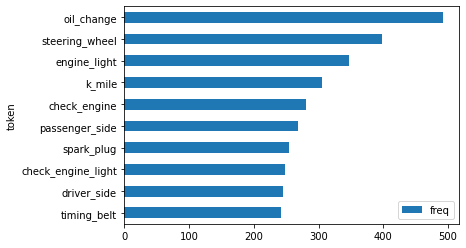

In [181]:
#Spacy also allows batch processing
batch_size = 50

#iterate over batches of the df...
for i in range(0, len(df), batch_size):
    #get a batch of text values and put them in a pipeline.
    docs = nlp.pipe(df['text'][i:i+batch_size])
    if(i%1000==0):
        print (f'Processing records: {i} out of {len(df)}...')
        
    for j, doc in enumerate(docs):
        for col, values in extract_nlp(doc).items():
             df[col].iloc[i+j] = values

#extract noun phrases as a sanity check
count_words(df, 'noun_phrases').head(10).plot(kind='barh').invert_yaxis()

In [182]:
#Saving results
df[nlp_columns] = df[nlp_columns].applymap(lambda items: ' '.join(items))
con = sqlite3.connect(db_name)
df.to_sql("posts_nlp", con, index=False, if_exists="replace")
con.close()

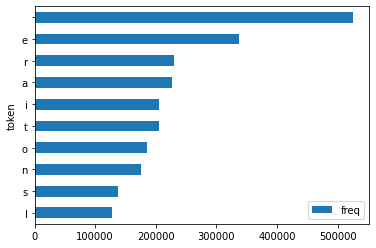

In [190]:
count_words(df, 'nouns').head(10).plot(kind='barh').invert_yaxis()